In [159]:
import pandas as pd
from math import pi
import math
import pickle
import operator
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [160]:
def preprocess(contents):
    '''
    Prepprocessin scrape data

    Parameters
    ----------
    contents: list of dicts
    - A list of dict scraped from allrecipes.com

    Returns
    contents: list of dicts
    '''
    
    for content in contents:
        content['ingredients'] = content['ingredients']
        content.pop('reviews', None)
        # content.pop('link', None)
        content.pop('catagories', None)
        content.pop('title', None)
        content['directions'].pop()
        content['num_directions'] = len(content['directions'])
        content['num_ingredients'] = len(content['ingredients'])
        content['low_rating'] = int(content['rating'] < 3 and content['rating'] > 0)
    
        float_list = ['calories', 'carbohydrate', 'cholesterol', 'fat', 'protein', 'sodium', 'preptime', 'cooktime']
        for attr in float_list:
            if content[attr] == None:
                content[attr] = float('NaN')
                continue
            items = content[attr].strip().split()
            content[attr] = float('NaN')
            for item in items:
                try:
                    content[attr] = float(item)
                    break
                except ValueError:
                    pass
            
        if content['preptime'] < 5:
            content['preptime'] *= 60        
        if content['cooktime'] < 5:
            content['cooktime'] *= 60    
            
        if (content['readyin_time'] == None):
            content['readyin_time'] = float('NaN')
            continue

        time_list = content['readyin_time'].split()
        num = 0.0
        for i in range(0, len(time_list), 2):
            if time_list[i + 1] == 'd':
                num += float(time_list[i]) * 24 * 60
            elif time_list[i + 1] == 'h':
                num += float(time_list[i]) * 60
            else:
                num += float(time_list[i])
        content['readyin_time'] = num
    return contents

In [161]:
pickle_in = open("allrecipes_Thai.pkl","rb")
allrecipes = pickle.load(pickle_in)
contents = preprocess(allrecipes)

In [162]:
from nltk.corpus import wordnet as wn
food = wn.synset('food.n.02')
f = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

In [163]:
ingredients = []
for i in range(len(contents)):
    for ingredient in contents[i]['ingredients']:
        ingredient = ingredient.split()
        ingredients += (ingredient)

In [164]:
ingredient_list = []
ingredient_out = []
for food in ingredients:
    if food in f:
        ingredient_list.append(food)
unwanted_words=['greens','green','pepper','cut','chili','chile','soy']
for word in ingredient_list:
    if word not in unwanted_words:
        ingredient_out.append(word)

In [165]:
counter=collections.Counter(ingredient_out)
sorted_x = sorted(counter.items(), key=operator.itemgetter(1))
ingredient_freq = sorted_x[-5:]
ingredient_fr = []
for i in range(0,len(ingredient_freq)):
    ingredient_fr.append(ingredient_freq[i][1])
for i in range(len(ingredient_fr)):
    ingredient_fr[i] = math.log(ingredient_fr[i])

In [166]:
word =str(ingredient_out)
wordcloud = WordCloud().generate(word)

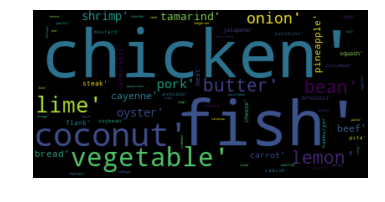

In [167]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [168]:
data = pd.read_csv("FAO.csv", encoding='latin-1')

In [169]:
llist=['Area', 'Item', 'Y2013']
country = data.loc[18817:18947, data.columns.isin(llist)]

In [170]:
Items = ['Coconuts - Incl Copra', 'Vegetables, Other','Fish, Seafood','Potatoes and products','Cereals, Other','Meat','Lemons, Limes and products']
country = country[country.Item.isin(Items)]

In [171]:
grp=country.groupby(['Item'])

In [221]:
#rice_sum = grp.get_group('Rice (Milled Equivalent)').sum(axis=1).sum()
veg_sum = grp.get_group('Vegetables, Other').sum(axis=1).sum()
coco_sum = grp.get_group('Coconuts - Incl Copra').sum(axis=1).sum()
fish_sum = grp.get_group('Fish, Seafood').sum(axis=1).sum()
cereal_sum = grp.get_group('Cereals, Other').sum(axis=1).sum()
potato_sum = grp.get_group('Potatoes and products').sum(axis=1).sum()
meat_sum = grp.get_group('Meat').sum(axis=1).sum()
lime_sum = grp.get_group('Lemons, Limes and products').sum(axis=1).sum()
dic = {}
#dic['Rice'] = rice_sum
#dic['Vegetables'] = veg_sum
dic['Lime'] = lime_sum
dic['Veggies'] = veg_sum
dic['Coconut'] = coco_sum
dic['Fish'] = fish_sum
dic['Chicken'] = meat_sum
#dic['Potato'] = cereal_sum


for key in dic.keys():
    dic[key] = math.log(dic[key])

In [222]:
categories = list(dic.keys())
print(categories)
#values = list(dic.values())
#values += values[:1]
N = len(categories)

['Lime', 'Veggies', 'Coconut', 'Fish', 'Chicken']


In [223]:
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

[4.68213122712422, 8.073091199693154, 6.532334292222349, 7.616283561580385, 7.583247524303362, 4.68213122712422]


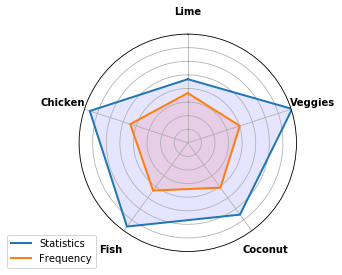

In [238]:
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories, color ='black',size=10, position=(0,-0.079), fontweight='bold')
ax.set_rlabel_position(0)
#plt.yticks([0,500,1000,1500,2000,2500, 3000], ["0","500","1000","1500","2000", "2500","3000"], color="grey", size=7)
#plt.ylim(0,3200)
plt.yticks([1,2,3,4,5,6,7,8], ["1","2","3","4","5","6","7","8"], color="black", size=1)
plt.ylim(0,8)

values = list(dic.values())
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Statistics")
ax.fill(angles, values, 'b', alpha=0.1)
print(values)

values = list(ingredient_fr)
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Frequency")
ax.fill(angles, values, 'r', alpha=0.1)


plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))